In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch


In [2]:
data = pd.read_csv('Reviews.csv')
data.shape

(568454, 10)

# Basic Data Filtering

In [3]:
data = data.dropna()
data.shape

(568411, 10)

In [4]:
import warnings
warnings.filterwarnings("ignore")                     #Ignoring unnecessory warnings

import numpy as np                                  #for large and multi-dimensional arrays
import pandas as pd

import nltk                                         #Natural language processing tool-kit

from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.stem import PorterStemmer                 # Stemmer

In [5]:
#basic cleaning
import time

data = data.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"})
data = data[data['HelpfulnessNumerator'] <= data['HelpfulnessDenominator']]

nltk.download('stopwords')

stop = set(stopwords.words('english'))

#removing spaces and stopwords
import re
# function to clean data
def clean_data(X):
    temp =[]
    snow = nltk.stem.SnowballStemmer('english')
    start = time.time()
    for i, sentence in enumerate(X):
        if i%10000 == 0:
            print(i, 'Time taken:', time.time()-start)
            start = time.time()
        sentence = sentence.lower()                 # Converting to lowercase
        cleanr = re.compile('<.*?>')
        sentence = re.sub(cleanr, ' ', sentence)        #Removing HTML tags
        sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
        sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence)        #Removing Punctuations

        words = [snow.stem(word) for word in sentence.split()]   # Stemming
        temp.append(words)

    X = temp    

    sent = []
    for row in X:
        sequ = ''
        for word in row:
            sequ = sequ + ' ' + word
        sent.append(sequ)

    return sent

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/klejdisevdari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
X, y = data['Text'], data['Score'] # extract features

<AxesSubplot:>

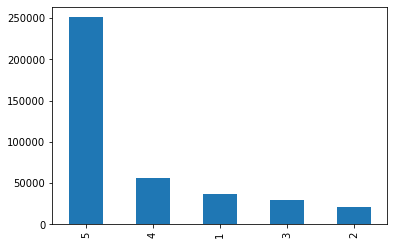

In [7]:
y.value_counts().plot(kind='bar') # check unbalanced data

<AxesSubplot:>

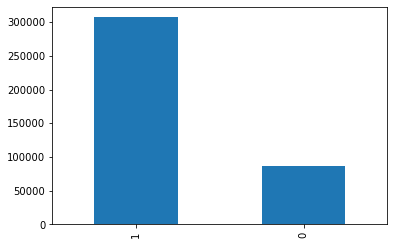

In [8]:
y[y<4] = 0 # negative class
y[y>=4] = 1 # positive class
y.value_counts().plot(kind='bar')

In [9]:
y = np.array(y) # to convert to numpy array

In [10]:
cleaned_data = clean_data(X)

0 Time taken: 1.5020370483398438e-05
10000 Time taken: 4.28208589553833
20000 Time taken: 4.668278932571411
30000 Time taken: 4.387677907943726
40000 Time taken: 4.543781042098999
50000 Time taken: 4.4371418952941895
60000 Time taken: 4.673625946044922
70000 Time taken: 4.925822973251343
80000 Time taken: 4.594944953918457
90000 Time taken: 4.531094074249268
100000 Time taken: 4.215704917907715
110000 Time taken: 4.376190900802612
120000 Time taken: 4.788803815841675
130000 Time taken: 4.298745155334473
140000 Time taken: 4.378087997436523
150000 Time taken: 4.532815217971802
160000 Time taken: 4.552306890487671
170000 Time taken: 4.392742156982422
180000 Time taken: 4.354651212692261
190000 Time taken: 4.448018789291382
200000 Time taken: 4.902785062789917
210000 Time taken: 4.437324047088623
220000 Time taken: 4.406347990036011
230000 Time taken: 4.66995906829834
240000 Time taken: 4.16654896736145
250000 Time taken: 4.375397205352783
260000 Time taken: 4.439316034317017
270000 Time 

In [11]:
len(cleaned_data), len(y) # checking if the length of cleaned data and y is same# Glove

(393917, 393917)

In [39]:
# creating train and validation

# get the indicies of the positive and negative classes
zero_indicies = np.where(y==0)[0]
one_indicies = np.where(y==1)[0]

# create validation indicies
val_indicies = np.concatenate([zero_indicies[:500], one_indicies[:500]])
max_val = np.max(val_indicies)

# create the validation data
y_val = y[val_indicies]
val_data = []
for i in val_indicies:
    val_data.append(cleaned_data[i])

# create train data
train_data = cleaned_data[max_val+1:]
y_train = y[max_val+1:]

print('Length of validation set', len(val_data), len(y_val))
print('Length of validation set', len(train_data), len(y_train))

# Santiy check
print('\n Example of bad Review: \n')
print(val_data[0])

print('\n Example of Good Review: \n')
print(val_data[-1])

# Note that the words are stemmed

Length of validation set 1000 1000
Length of validation set 391698 391698

 Example of bad Review: 

 product arriv label as jumbo salt peanut the peanut were actual small size unsalt not sure if this was an error or if the vendor intend to repres the product as jumbo

 Example of Good Review: 

 the tea tin is guard the aroma veri well the tast is beautiful: the malva flower do soften the tast and the amount of bergamot is just right the first time i use too much tea and soak it for too long i use as refer darjeel ftgfop first flush sinc then i save on the quantiti of tea leav and soak the tea for onli two minut a delight: the best earl grey i ever had the price is veri competit


# Glove

In [40]:
# build a vocabulary
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('basic_english')
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)
vocab = build_vocab_from_iterator(yield_tokens(cleaned_data), specials=["<unk>"])

In [41]:
vocab(['hello', 'how']) # sanity check

[3953, 173]

In [42]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [43]:
glove_file = "glove.840B.300d.txt"

In [44]:
#takes about 1 minute to read through the whole file and find the words we need. 
def get_glove_mapping(vocab, file):
    
    # Gets the mapping of words from the vocabulary to pretrained embeddings
    
    glove_map = {}
    with open(file,'rb') as fi:
        for i, l in enumerate(fi):
            try:
                line = l.decode('utf-8')
                line = line.split(' ')
                word = line[0]
                if word in vocab:
                    array = np.array(line[1:], dtype=np.float)
                    glove_map[word] = array
            except:
                # print('some sort of error')
                #some lines have urls, we don't need them.
                pass
    return glove_map

In [45]:
glove_map = get_glove_mapping(vocab,glove_file)

In [47]:
def get_weight_matrix(n_embed, d_embed, glove_map):
    
    # Initialize the weight matrix
    weights_matrix = np.random.normal(size=(n_embed, d_embed))

    for i, word in enumerate(vocab.get_itos()):
      if word in glove_map:
        weights_matrix[i] = glove_map[word]
    
    return weights_matrix

In [48]:
weights_matrix = get_weight_matrix(len(vocab), 300, glove_map).astype('float32')

In [49]:
weights_matrix[vocab(['hello', 'how'])].shape # sanity check

(2, 300)

# Data Processing and Helper Functions

In [51]:
# Helper functions that convert sentences into Pytorch tensors
def sentenceToTensor(line, batch=True):
    entries = text_pipeline(line)
    tensor = torch.from_numpy(weights_matrix[entries])
    if batch:
        return tensor.unsqueeze(1)
    return tensor

def wordToTensor(word):
    entries = text_pipeline(word)
    return torch.from_numpy(weights_matrix[entries])

## Resolving the unbalanced data issue
The function below is used in the training loop and it generates senteces of each sentiment with equal probability. This is in an attempt to resolve the unbalanced data issue. Otherwise, the classifer might see a majority of positive sentiment sentences and have a bias towards classifying most sentences as positive.

In [54]:
# Get the indicies of the training set
zero_indicies = np.where(y_train==0)[0]
one_indicies = np.where(y_train==1)[0]

def randomTrainingExample(data, batch=True):
    # Flip a coin
    coin = np.random.uniform()

    random = None
    if coin > 0.5:
        random = np.random.randint(0, len(zero_indicies))
        random = zero_indicies[random]
    else:
         random = np.random.randint(0, len(one_indicies))
         random = one_indicies[random]
    
    # get the training examples
    tensor = sentenceToTensor(data[random], batch=batch)
    category = torch.tensor([[y_train[random]]], dtype=torch.float)
    return category, tensor

cat, input = randomTrainingExample(train_data)
print(cat.shape, input.shape) # sanity check
# input shape should be [no_words, batch, embedding_dim] if batch=True

torch.Size([1, 1]) torch.Size([31, 1, 300])


## Getting the accuracies of the validation set

In [61]:
def get_accuracyLTSM(model):
  with torch.no_grad():
    count = 0 # count the correct instances

    for i in range(len(val_data)):
      # get sentence and convert to tensor
      sentence = val_data[i]
      sentence = sentenceToTensor(sentence)
      category = torch.tensor([[y_val[i]]], dtype=torch.float)

      # get prediction
      pred = model(sentence)
      # print(category.item(), pred.item())

      # check accuracy
      classification = 1 if pred.item() > 0.5 else 0
      if classification == category.item():
          count+= 1
    
    # return the accuracy
    return count/len(val_data)
# get_accuracyLTSM(model)

# LSTM

## Define the Model

In [62]:
# define the LSTM model
import torch.nn as nn

class LSTM(nn.Module):

    def __init__(self, embedding_dim):
        super(LSTM, self).__init__()

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, embedding_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(embedding_dim, 1)

    def forward(self, sentence):
        
        lstm_out, _ = self.lstm(sentence)
        logit = self.hidden2tag(lstm_out[-1])
        prob = nn.functional.sigmoid(logit)
        return prob

model = LSTM(300)

## Train the model

In [63]:
import torch.optim as optim
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

loss_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
current_loss = 0
start = time.time()

n_iters = 100000
print_every = 5000


start = time.time()

for iter in range(1, n_iters+1): 
    # Step 1. Remember that Pytorch accumulates gradients.
    # We need to clear them out before each instance
    model.zero_grad()

    # Step 2. Get our inputs ready for the network, that is, turn them into
    # Tensors of word indices.
    category, sentence = randomTrainingExample(train_data, batch=False)
    category = category[0]
    # Step 3. Run our forward pass.
    output = model(sentence)

    # Step 4. Compute the loss, gradients, and update the parameters by
    #  calling optimizer.step()
    loss = loss_function(output, category)
    current_loss += loss.item()
    loss.backward()
    optimizer.step()
    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        acc = get_accuracyLTSM(model)
        print('%d %d%% (%s) %.4f' % (iter, iter / n_iters * 100, timeSince(start), current_loss/print_every))
        print('Accuracy:', acc)
        current_loss = 0


5000 5% (2m 15s) 0.6808
Accuracy: 0.644
10000 10% (4m 29s) 0.6296
Accuracy: 0.632
15000 15% (6m 43s) 0.5941
Accuracy: 0.597
20000 20% (8m 56s) 0.6243
Accuracy: 0.713
25000 25% (11m 6s) 0.5638
Accuracy: 0.577
